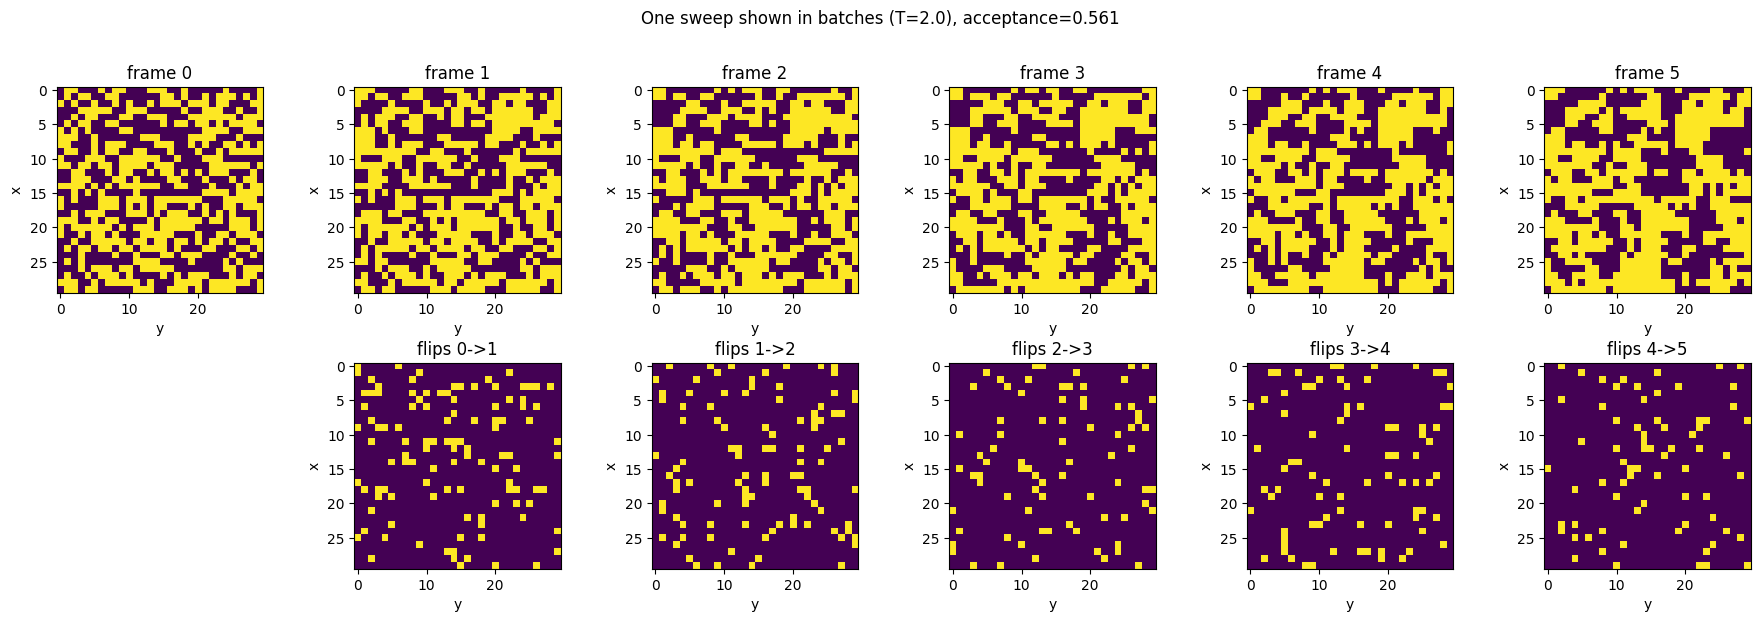

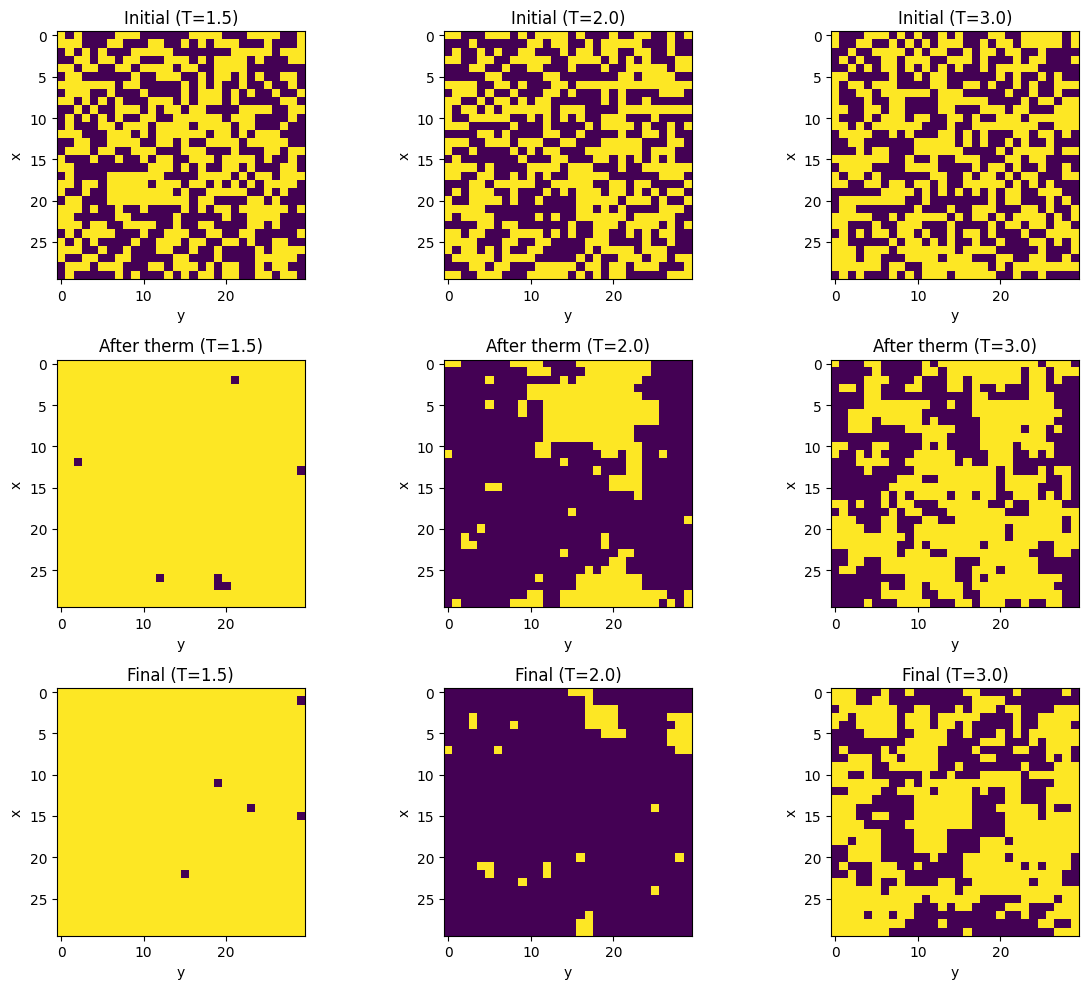

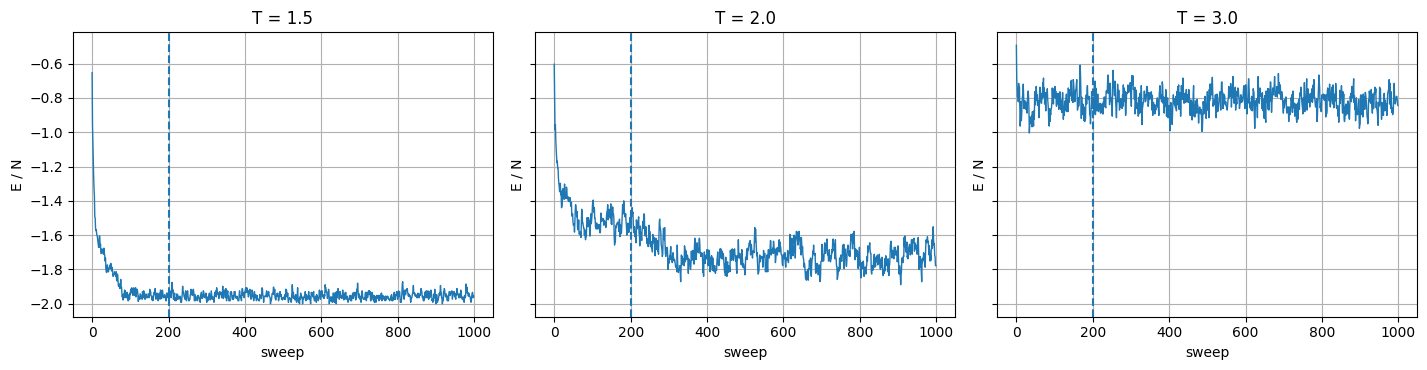

T = 1.5
<E>/N = -1.953978

T = 2.0
<E>/N = -1.710917

T = 3.0
<E>/N = -0.816094



In [ ]:
# Part 1 (a–d): Metropolis, sweep, energy
import numpy as np
import matplotlib.pyplot as plot

def hamiltonian(spins, kappa, h):
    n = spins.shape[0]
    bond_sum = 0
    for x in range(n):
        for y in range(n):
            s = spins[x, y]
            bond_sum += s * spins[(x + 1) % n, y]
            bond_sum += s * spins[x, (y + 1) % n]
    return float(-kappa * bond_sum - h * np.sum(spins))

def deltaH(spins, x, y, kappa, h):
    n = spins.shape[0]
    s = spins[x, y]
    nn = (
        spins[(x + 1) % n, y] + spins[(x - 1) % n, y] +
        spins[x, (y + 1) % n] + spins[x, (y - 1) % n]
    )
    return float(2.0 * s * (kappa * nn + h))

def metropolis_step(spins, kappa, h, T, rng):
    n = spins.shape[0]
    x = int(rng.integers(0, n))
    y = int(rng.integers(0, n))
    dH = deltaH(spins, x, y, kappa, h)

    if dH <= 0.0 or rng.random() < np.exp(-dH / T):
        spins[x, y] *= -1
        return True
    return False

def sweep(spins, kappa, h, T, rng):
    acc = 0
    for _ in range(spins.size):
        acc += int(metropolis_step(spins, kappa, h, T, rng))
    return acc / spins.size

def demo_sweep_batches(spins, kappa, h, T, rng, n_frames=6):
    N = spins.size
    step_points = np.linspace(0, N, n_frames, dtype=int)

    snaps = [spins.copy()]
    flips = []

    acc = 0
    prev = spins.copy()
    target_idx = 1

    for step in range(1, N + 1):
        acc += int(metropolis_step(spins, kappa, h, T, rng))

        if target_idx < len(step_points) and step == step_points[target_idx]:
            curr = spins.copy()
            flips.append(curr != prev)
            snaps.append(curr)
            prev = curr
            target_idx += 1

    return snaps, flips, acc / N

def demo_sweep_batches(spins, kappa, h, T, rng, n_frames=6):
    N = spins.size
    step_points = np.linspace(0, N, n_frames, dtype=int)

    snaps = [spins.copy()]
    flips = []

    acc = 0
    prev = spins.copy()
    target_idx = 1

    for step in range(1, N + 1):
        acc += int(metropolis_step(spins, kappa, h, T, rng))

        if target_idx < len(step_points) and step == step_points[target_idx]:
            curr = spins.copy()
            flips.append(curr != prev)
            snaps.append(curr)
            prev = curr
            target_idx += 1

    return snaps, flips, acc / N

def plot_sweep_demo(snaps, flips, T, acc):
    n_frames = len(snaps)
    fig, axes = plot.subplots(2, n_frames, figsize=(3.0 * n_frames, 6.0))
    if n_frames == 1:
        axes = np.array(axes).reshape(2, 1)

    for i in range(n_frames):
        axes[0, i].imshow(snaps[i], vmin=-1, vmax=1, interpolation="nearest")
        axes[0, i].set_title(f"frame {i}")
        axes[0, i].set_xlabel("y")
        axes[0, i].set_ylabel("x")

    axes[1, 0].axis("off")
    for i in range(1, n_frames):
        axes[1, i].imshow(flips[i - 1], interpolation="nearest")
        axes[1, i].set_title(f"flips {i-1}->{i}")
        axes[1, i].set_xlabel("y")
        axes[1, i].set_ylabel("x")

    fig.suptitle(f"One sweep shown in batches (T={T}), acceptance={acc:.3f}", y=1.02)
    plot.tight_layout()
    plot.show()

def run_mc_part1(n, kappa, h, T, n_therm, n_sweeps, seed=None):
    rng = np.random.default_rng(seed)
    spins = rng.choice([-1, 1], size=(n, n)).astype(int)

    spins_init = spins.copy()

    E_th = np.empty(n_therm)
    A_th = np.empty(n_therm)
    for t in range(n_therm):
        A_th[t] = sweep(spins, kappa, h, T, rng)
        E_th[t] = hamiltonian(spins, kappa, h) / spins.size

    spins_after_therm = spins.copy()

    E_me = np.empty(n_sweeps)
    A_me = np.empty(n_sweeps)
    for t in range(n_sweeps):
        A_me[t] = sweep(spins, kappa, h, T, rng)
        E_me[t] = hamiltonian(spins, kappa, h) / spins.size

    spins_final = spins.copy()
    return spins_init, spins_after_therm, spins_final, E_th, A_th, E_me, A_me

def plot_lattice(ax, spins, title):
    im = ax.imshow(spins, vmin=-1, vmax=1, interpolation="nearest")
    ax.set_title(title)
    ax.set_xlabel("y")
    ax.set_ylabel("x")
    return im

def plot_lattices_part1(all_runs_part1, T_list):
    fig, axes = plot.subplots(3, len(T_list), figsize=(4.0 * len(T_list), 10))
    if len(T_list) == 1:
        axes = np.array(axes).reshape(3, 1)

    for j, T in enumerate(T_list):
        sp0, spT, spF, *_ = all_runs_part1[j]
        plot_lattice(axes[0, j], sp0, f"Initial (T={T})")
        plot_lattice(axes[1, j], spT, f"After therm (T={T})")
        plot_lattice(axes[2, j], spF, f"Final (T={T})")

    plot.tight_layout()
    plot.show()

def plot_energy_timeseries_part1(all_runs_part1, T_list):
    fig, axes = plot.subplots(1, len(T_list), figsize=(4.8 * len(T_list), 3.8), sharey=True)
    if len(T_list) == 1:
        axes = [axes]

    for j, T in enumerate(T_list):
        sp0, spT, spF, E_th, A_th, E_me, A_me = all_runs_part1[j]
        E_all = np.concatenate([E_th, E_me])
        cut = len(E_th)

        ax = axes[j]
        ax.plot(E_all, linewidth=1)
        ax.axvline(cut, linestyle="--")
        ax.set_title(f"T = {T}")
        ax.set_xlabel("sweep")
        ax.set_ylabel("E / N")
        ax.grid(True)

    plot.tight_layout()
    plot.show()

def print_energy_stats_part1(T, E_me):
    print(f"T = {T}")
    print(f"<E>/N = {np.mean(E_me):.6f}")
    print()

if __name__ == "__main__":
    n = 30
    kappa = 1.0
    h = 0.0

    T_list = [1.5, 2.0, 3.0]
    n_therm = 200
    n_sweeps = 800
    # seed = 1446

    # Sweep, local updates
    T_demo = 2.0
    rng = np.random.default_rng(None)
    spins_demo = rng.choice([-1, 1], size=(n, n)).astype(int)

    snaps, flips, acc = demo_sweep_batches(spins_demo, kappa, h, T_demo, rng, n_frames=6)
    plot_sweep_demo(snaps, flips, T_demo, acc)
    
    all_runs_part1 = []
    for T in T_list:
        all_runs_part1.append(run_mc_part1(n, kappa, h, T, n_therm, n_sweeps))

    plot_lattices_part1(all_runs_part1, T_list)
    plot_energy_timeseries_part1(all_runs_part1, T_list)

    for run, T in zip(all_runs_part1, T_list):
        _, _, _, _, _, E_me, _ = run
        print_energy_stats_part1(T, E_me)

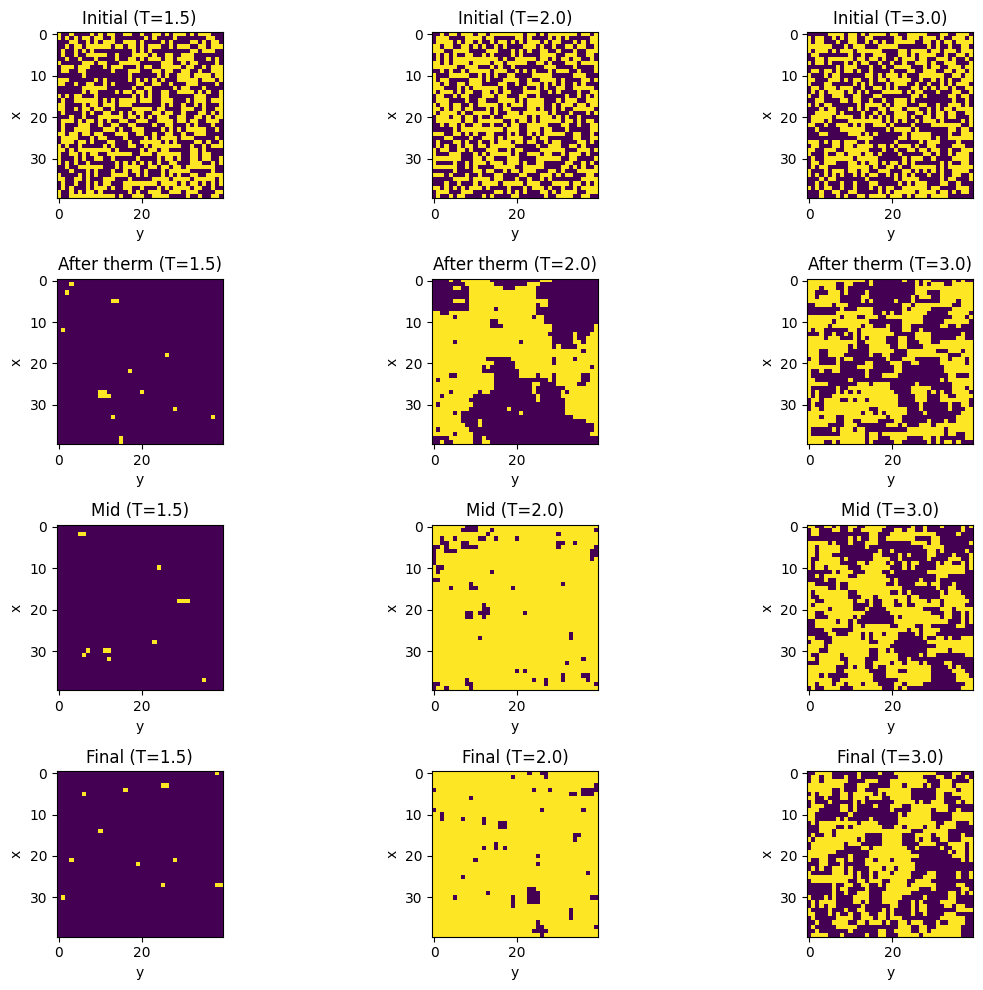

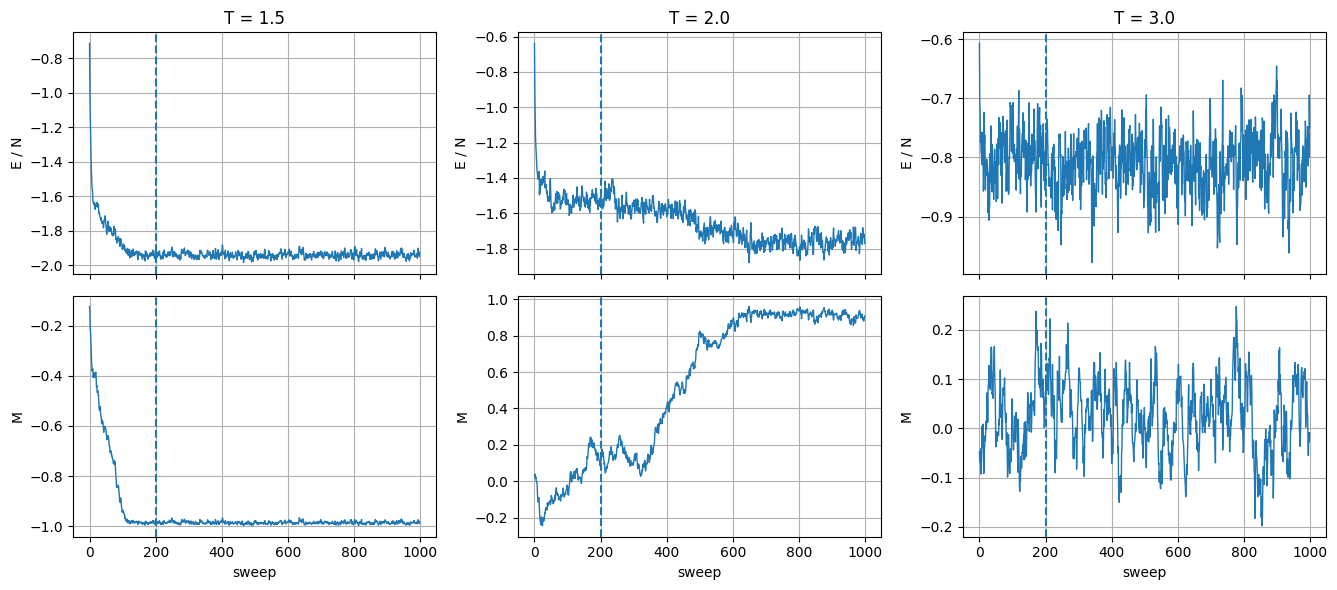

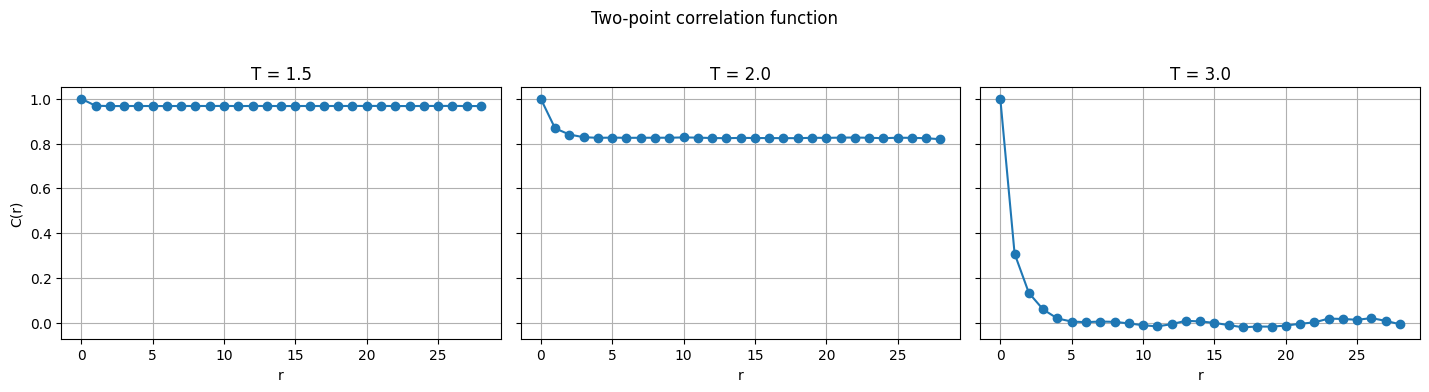

T = 1.5
<E>/N = -1.941326
<m> = -0.986436
<|m|> = 0.986436
<m^2> = 0.973082
chi = 1.556931e+03

T = 2.0
<E>/N = -1.682047
<m> = 0.665625
<|m|> = 0.665625
<m^2> = 0.543507
chi = 8.696118e+02

T = 3.0
<E>/N = -0.811153
<m> = 0.025584
<|m|> = 0.062347
<m^2> = 0.005885
chi = 9.416569e+00



In [ ]:
# Part 2: magnetization, correlation, susceptibility
def correlation_map_fft(spins):
    s = spins.astype(float)
    N = s.size
    F = np.fft.fft2(s)
    C = np.fft.ifft2(np.abs(F) ** 2).real / N
    return C

def radial_average_corr(C):
    n = C.shape[0]
    r_max = int(np.floor(np.sqrt(2) * (n // 2)))
    sums = np.zeros(r_max + 1, dtype=float)
    counts = np.zeros(r_max + 1, dtype=int)

    for dx in range(n):
        ddx = min(dx, n - dx)
        for dy in range(n):
            ddy = min(dy, n - dy)
            r = int(np.rint(np.sqrt(ddx ** 2 + ddy ** 2)))
            if r <= r_max:
                sums[r] += C[dx, dy]
                counts[r] += 1

    Cr = np.zeros_like(sums)
    mask = counts > 0
    Cr[mask] = sums[mask] / counts[mask]
    return np.arange(r_max + 1), Cr

def magnetization(spins):
    return float(np.sum(spins) / spins.size)

def susceptibility_chi(M_series, n):
    return float((n * n) * np.mean(M_series ** 2))

def run_mc_part2(n, kappa, h, T, n_therm, n_sweeps, seed=None):
    rng = np.random.default_rng(seed)
    spins = rng.choice([-1, 1], size=(n, n)).astype(int)

    spins_init = spins.copy()

    E_th = np.empty(n_therm)
    M_th = np.empty(n_therm)
    A_th = np.empty(n_therm)

    for t in range(n_therm):
        A_th[t] = sweep(spins, kappa, h, T, rng)
        E_th[t] = hamiltonian(spins, kappa, h) / spins.size
        M_th[t] = magnetization(spins)

    spins_after_therm = spins.copy()

    E_me = np.empty(n_sweeps)
    M_me = np.empty(n_sweeps)
    A_me = np.empty(n_sweeps)

    spins_mid = None
    for t in range(n_sweeps):
        A_me[t] = sweep(spins, kappa, h, T, rng)
        E_me[t] = hamiltonian(spins, kappa, h) / spins.size
        M_me[t] = magnetization(spins)
        if t == n_sweeps // 2:
            spins_mid = spins.copy()

    return spins_init, spins_after_therm, spins_mid, spins.copy(), E_th, M_th, A_th, E_me, M_me, A_me

def plot_lattices_part2(all_runs_part2, T_list):
    fig, axes = plot.subplots(4, len(T_list), figsize=(4.0 * len(T_list), 10))
    if len(T_list) == 1:
        axes = np.array(axes).reshape(4, 1)

    for j, T in enumerate(T_list):
        sp0, spT, spI, spF, *_ = all_runs_part2[j]
        plot_lattice(axes[0, j], sp0, f"Initial (T={T})")
        plot_lattice(axes[1, j], spT, f"After therm (T={T})")
        plot_lattice(axes[2, j], spI, f"Mid (T={T})")
        plot_lattice(axes[3, j], spF, f"Final (T={T})")

    plot.tight_layout()
    plot.show()

def plot_timeseries_EM_part2(all_runs_part2, T_list):
    fig, axes = plot.subplots(2, len(T_list), figsize=(4.5 * len(T_list), 6), sharex="col")
    if len(T_list) == 1:
        axes = np.array(axes).reshape(2, 1)

    for j, T in enumerate(T_list):
        _, _, _, _, E_th, M_th, _, E_me, M_me, _ = all_runs_part2[j]
        E_all = np.concatenate([E_th, E_me])
        M_all = np.concatenate([M_th, M_me])
        cut = len(E_th)

        ax = axes[0, j]
        ax.plot(E_all, linewidth=1)
        ax.axvline(cut, linestyle="--")
        ax.set_title(f"T = {T}")
        ax.set_ylabel("E / N")
        ax.grid(True)

        ax = axes[1, j]
        ax.plot(M_all, linewidth=1)
        ax.axvline(cut, linestyle="--")
        ax.set_ylabel("M")
        ax.set_xlabel("sweep")
        ax.grid(True)

    plot.tight_layout()
    plot.show()

def plot_corr_subplots_part2(all_runs_part2, T_list):
    fig, axes = plot.subplots(1, len(T_list), figsize=(4.8 * len(T_list), 3.8), sharey=True)
    if len(T_list) == 1:
        axes = [axes]

    for j, T in enumerate(T_list):
        sp0, spT, spI, spF, E_th, M_th, A_th, E_me, M_me, A_me = all_runs_part2[j]

        C = correlation_map_fft(spF)
        r, Cr = radial_average_corr(C)

        ax = axes[j]
        ax.plot(r, Cr, marker="o")
        ax.set_title(f"T = {T}")
        ax.set_xlabel("r")
        ax.grid(True)

    axes[0].set_ylabel("C(r)")
    fig.suptitle("Two-point correlation function", y=1.02)
    plot.tight_layout()
    plot.show()

def plot_chi_vs_T_part2(all_runs_part2, T_list, n):
    chi_list = []
    for run in all_runs_part2:
        _, _, _, _, _, _, _, _, M_me, _ = run
        chi_list.append((n*n) * np.mean(M_me**2))

    fig, ax = plot.subplots()
    ax.plot(T_list, chi_list, marker="o")
    ax.set_xlabel("T")
    ax.set_ylabel(r"$\chi = N\langle m^2\rangle$")
    ax.grid(True)
    plot.show()

def print_stats_part2(T, E_me, M_me, n):
    N = n*n
    print(f"T = {T}")
    print(f"<E>/N = {np.mean(E_me):.6f}")
    print(f"<m> = {np.mean(M_me):.6f}")
    print(f"<|m|> = {np.mean(np.abs(M_me)):.6f}")
    print(f"<m^2> = {np.mean(M_me**2):.6f}")
    print(f"chi = {N*np.mean(M_me**2):.6e}")
    print()

if __name__ == "__main__":
    n = 40
    kappa = 1.0
    h = 0.01

    T_list = [1.5, 2.0, 3.0]
    n_therm = 200
    n_sweeps = 800

    all_runs_part2 = []
    for T in T_list:
        all_runs_part2.append(run_mc_part2(n, kappa, h, T, n_therm, n_sweeps))

    plot_lattices_part2(all_runs_part2, T_list)
    plot_timeseries_EM_part2(all_runs_part2, T_list)
    plot_corr_subplots_part2(all_runs_part2, T_list)
    # plot_chi_vs_T_part2(all_runs_part2, T_list, n)

    for run, T in zip(all_runs_part2, T_list):
        _, _, _, _, _, _, _, E_me, M_me, _ = run
        print_stats_part2(T, E_me, M_me, n)

# def plot_acceptance(all_runs, T_list):
#     fig, axes = plot.subplots(1, len(T_list), figsize=(4.5 * len(T_list), 3), sharey=True)
#     if len(T_list) == 1:
#         axes = [axes]
#
#     for j, T in enumerate(T_list):
#         # FIX: правильная распаковка (10 элементов)
#         _, _, _, _, _, _, A_th, _, _, A_me = all_runs[j]
#         A_all = np.concatenate([A_th, A_me])
#         cut = len(A_th)
#
#         ax = axes[j]
#         ax.plot(A_all, linewidth=1)
#         ax.axvline(cut, linestyle="--")
#         ax.set_title(f"T = {T}")
#         ax.set_xlabel("sweep")
#         ax.grid(True)
#
#     axes[0].set_ylabel("acceptance")
#     plot.tight_layout()
#     plot.show()

# def plot_three_endplots(E_me, M_me, spins_final, T):
#     C = correlation_map_fft(spins_final)
#     r, Cr = radial_average_corr(C)
#
#     fig, axes = plot.subplots(1, 3, figsize=(14, 4))
#
#     axes[0].hist(E_me, bins=40, density=True)
#     axes[0].set_xlabel("E / N")
#     axes[0].set_ylabel("density")
#     axes[0].set_title(f"Energy histogram (T={T})")
#     axes[0].grid(True)
#
#     axes[1].hist(M_me, bins=40, density=True)
#     axes[1].set_xlabel("M")
#     axes[1].set_ylabel("density")
#     axes[1].set_title(f"Magnetization histogram (T={T})")
#     axes[1].grid(True)
#
#     axes[2].plot(r, Cr, marker="o")
#     axes[2].set_xlabel("r")
#     axes[2].set_ylabel("C(r)")
#     axes[2].set_title(f"Two-point correlation (T={T})")
#     axes[2].grid(True)
#
#     plot.tight_layout()
#     plot.show()